In [1]:
import os

import pandas as pd
from ast import literal_eval

In [2]:
# Ensure the project directory is set correctly
if not set(["notebooks", "scripts"]).issubset(os.listdir()):
    os.chdir(os.path.dirname(os.getcwd()))

In [3]:
from scripts import analysis_helper

from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
# Define file paths
job_prg_name_filename = "data/interim/post_processing_job_postings.csv"
job_timeline_filename = "data/interim/post_processing_job_timeline.csv"
foundal_skills_filename = "data/interim/post_processing_soft_skills.csv"
replace_skills_prg_name = "data/interim/replace_skills_job_programs.csv"
replace_skills_timeline = "data/interim/replace_skills_job_timeline.csv"

In [5]:
# Check if running in Google Colab
try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [6]:
# Mount Google Drive and adjust file paths if in Google Colab
if IN_COLAB:
    drive_mounted_path = "/content/drive"

    if not os.path.exists(drive_mounted_path):
        from google.colab import drive

        drive.mount(drive_mounted_path)

    project_dir = "My Drive/School/UoGuelph/MSc/Research/soft_skills_job_desc/jfraeysd"
    job_prg_name_filename = os.path.join(drive_mounted_path, project_dir, job_prg_name_filename)
    job_timeline_filename = os.path.join(drive_mounted_path, project_dir, job_timeline_filename)
    replace_skills_prg_name = os.path.join(drive_mounted_path, project_dir, replace_skills_prg_name)
    replace_skills_timeline = os.path.join(drive_mounted_path, project_dir, replace_skills_timeline)
    foundal_skills_filename = os.path.join(
        drive_mounted_path, project_dir, foundal_skills_filename
    )

# Reading the foundational skills

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
# Import soft skills data
df_soft_skills = pd.read_csv(foundal_skills_filename)

In [9]:
# Read str as list in csv files
# df_soft_skills['alt_labels']=df_soft_skills['alt_labels'].apply(literal_eval)
df_soft_skills['alt_labels_lemm']=df_soft_skills['alt_labels_lemm'].apply(literal_eval)

# Reading job posting and replacing the alt_labels with the lemmatized alt_labels

In [10]:
# Read job description data
df_coop_prg_name = pd.read_csv(replace_skills_prg_name)
df_coop_timeline = pd.read_csv(replace_skills_timeline)

In [11]:
df_coop_timeline['date_goes_live'] = pd.to_datetime(df_coop_timeline['date_goes_live'])

In [12]:
df_coop_timeline['year'] = df_coop_timeline['date_goes_live'].dt.year

In [13]:
word_mapping = dict(zip(df_soft_skills['soft_skill_lemm'], df_soft_skills['alt_labels_lemm']))

In [20]:
df_coop_prg_name.shape

(75519, 7)

In [14]:
text_column = 'job_description_replaced_skills'
grp_prg_name = df_coop_prg_name.groupby('program_name')

In [15]:
grp_prg_name.size()

program_name
Biological Engineering              8644
Biomedical Engineering              6640
Computer Engineering               11076
Computer Science                    9110
Engineering Systems & Computing    12008
Environmental Engineering           6497
Mechanical Engineering              6240
Software Engineering                9016
Water Resources Engineering         6288
dtype: int64

In [16]:
grouped_data_term_frequencies = grp_prg_name.progress_apply(lambda group: analysis_helper.calculate_term_frequencies(group, text_column, word_mapping.keys()))
grouped_data_term_counts = grp_prg_name.progress_apply(lambda group: analysis_helper.calculate_term_counts(group, text_column, word_mapping.keys()))
grouped_data_document_frequencies = grp_prg_name.progress_apply(lambda group: analysis_helper.calculate_document_frequencies(group, text_column, word_mapping.keys()))

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [17]:
count_skills_prg_name = analysis_helper.calculate_posting_counts_by_skills(grp_prg_name, text_column, word_mapping.keys())

Calculating posting counts: 100%|██████████| 9/9 [06:33<00:00, 43.68s/it]


In [18]:
count_skills_prg_name.sort_index(axis=1)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Biological Engineering,135,306,480,599,679,802,785,797,735,720,...,63,49,53,29,13,4,1,0,0,1
Biomedical Engineering,97,208,338,401,513,598,582,631,608,576,...,59,40,53,16,13,7,1,1,0,0
Computer Engineering,82,159,307,411,627,759,799,932,997,1001,...,184,148,93,78,28,16,14,5,2,1
Computer Science,69,121,227,308,443,550,619,750,789,828,...,181,118,87,57,41,9,10,8,6,0
Engineering Systems & Computing,98,182,322,470,685,796,931,1009,1057,1073,...,203,139,119,75,32,12,11,9,4,0
Environmental Engineering,96,228,370,495,499,624,616,567,552,495,...,73,37,38,26,13,7,1,0,0,0
Mechanical Engineering,84,148,258,377,448,510,572,616,599,540,...,60,51,48,27,10,7,2,1,0,1
Software Engineering,64,120,219,295,459,530,599,725,837,795,...,174,137,81,55,33,18,14,6,3,1
Water Resources Engineering,97,212,367,471,477,626,584,540,566,464,...,60,46,38,27,11,1,1,1,0,0


In [19]:
count_skills_prg_name_sorted = count_skills_prg_name.sort_index(axis=1)
count_skills_prg_name_sorted.to_csv('count_skills_prg_name_sorted.csv')


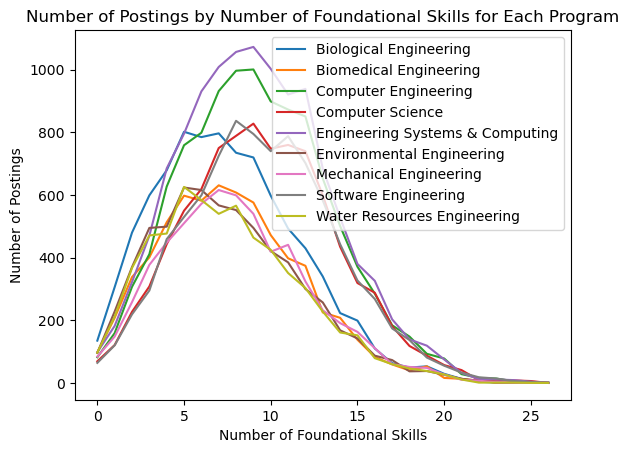

In [20]:
analysis_helper.plot_line_graph(count_skills_prg_name.sort_index(axis=1), 'Number of Postings by Number of Foundational Skills for Each Program')

In [21]:
document_counts_tf_prg_name = analysis_helper.count_document_per_group_with_term_occurrences(grp_prg_name, text_column=text_column, terms=word_mapping.keys())

Counting documents per group: 100%|██████████| 9/9 [01:11<00:00,  7.99s/it]


In [22]:
analysis_helper.create_all_skill_tables(document_counts_tf_prg_name, 'reports/document_counts_tf_prg_name.xlsx')

In [23]:
term_occurrences_per_prg_name = analysis_helper.count_document_per_group_with_total_term_occurrences(grp_prg_name, text_column, word_mapping.keys())

Counting documents per group with total term occurrences: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it]


In [24]:
term_occurrences_per_prg_name.to_csv('reports/term_occurrences_per_prg_name.csv')
term_occurrences_per_prg_name

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
Biological Engineering,135,254,376,413,439,538,529,532,506,483,...,0,0,0,0,0,0,0,0,0,1
Biomedical Engineering,97,164,262,275,332,395,366,402,409,398,...,0,0,0,0,0,0,0,0,1,0
Computer Engineering,82,134,191,252,420,411,476,528,532,580,...,0,0,0,0,1,0,0,0,0,0
Computer Science,69,107,137,185,318,263,373,357,442,451,...,1,0,0,0,0,1,0,0,0,0
Engineering Systems & Computing,98,149,200,280,474,455,525,559,571,675,...,0,0,0,0,1,0,0,0,1,0
Environmental Engineering,96,194,280,332,330,445,395,403,388,363,...,0,0,0,0,0,0,0,0,0,0
Mechanical Engineering,84,113,185,226,306,351,345,372,350,431,...,0,0,0,0,0,0,0,1,0,0
Software Engineering,64,102,135,184,319,263,356,368,404,447,...,0,0,0,0,0,0,1,0,0,0
Water Resources Engineering,97,180,276,320,313,439,393,383,378,337,...,0,0,0,0,0,0,0,0,0,0


In [26]:
print("Term Count:")

# Compute average along rows (axis=1)
average_values = grouped_data_term_counts.sum(axis=0)

# Sort the pivot table based on average values
grouped_data_term_counts = grouped_data_term_counts[average_values.sort_values(ascending=False).index]

grouped_data_term_counts.to_csv("reports/prg_name_term_counts.csv")

grouped_data_term_counts


Term Count:


,keyword,active listen,goal,accountability,decision,decision make,creativity,curiosity,analytical,diverse,commitment,...,speak,negotiation,influence,hospitality,kindness,conflict management,social skill,persuasion,interpersonal communication,self organize
program_name,,,,,,,,,,,,,,,,,,,,,,
Biological Engineering,term_count,10454,9130,9378,6658,5991,3742,3184,3484,2811,2934,...,249,368,147,52,172,34,23,7,2,0
Biomedical Engineering,term_count,8070,6628,7357,5496,5008,3286,2517,2846,2167,2226,...,207,301,120,37,158,31,18,6,2,0
Computer Engineering,term_count,17743,12313,11673,12501,11057,9094,5517,5028,5221,5007,...,501,404,365,350,249,29,17,19,10,7
Computer Science,term_count,15517,10286,9589,10254,8922,8102,4824,4724,4497,4320,...,441,291,365,349,203,25,13,18,7,7
Engineering Systems & Computing,term_count,18851,13244,12688,13517,12007,9692,5847,5217,5537,5317,...,537,425,386,354,280,32,18,17,13,7
Environmental Engineering,term_count,8071,7675,6621,5447,4869,2511,2506,2053,2240,2222,...,203,291,108,44,99,29,17,4,4,0
Mechanical Engineering,term_count,7846,6643,6823,6304,5773,3329,2337,1809,2217,2238,...,203,303,117,53,142,30,11,7,6,1
Software Engineering,term_count,15212,10162,9489,10374,9079,8121,4744,4643,4473,4299,...,443,286,364,349,201,24,13,17,5,7
Water Resources Engineering,term_count,7802,7462,6405,5331,4753,2418,2422,1958,2164,2136,...,199,307,105,40,94,28,17,4,3,0


In [27]:
print("Term Frequencies:")

# Compute average along rows (axis=1)
average_values = grouped_data_term_frequencies.mean(axis=0)

# Sort the pivot table based on average values
grouped_data_term_frequencies = grouped_data_term_frequencies[average_values.sort_values(ascending=False).index]

grouped_data_term_frequencies.to_csv("reports/prg_name_term_freq.csv")

grouped_data_term_frequencies

Term Frequencies:


,keyword,active listen,goal,accountability,decision,decision make,creativity,curiosity,analytical,diverse,commitment,...,eagerness,speak,influence,kindness,hospitality,conflict management,social skill,persuasion,interpersonal communication,self organize
program_name,,,,,,,,,,,,,,,,,,,,,,
Biological Engineering,term_frequency,0.004879,0.004261,0.004377,0.003107,0.002796,0.001746,0.001486,0.001626,0.001312,0.001369,...,0.000101,0.000116,0.000069,0.000080,0.000024,0.000016,0.000011,0.000003,9.333700e-07,0.000000e+00
Biomedical Engineering,term_frequency,0.004969,0.004081,0.004530,0.003384,0.003084,0.002023,0.001550,0.001752,0.001334,0.001371,...,0.000102,0.000127,0.000074,0.000097,0.000023,0.000019,0.000011,0.000004,1.231447e-06,0.000000e+00
Computer Engineering,term_frequency,0.005661,0.003929,0.003724,0.003989,0.003528,0.002902,0.001760,0.001604,0.001666,0.001598,...,0.000185,0.000160,0.000116,0.000079,0.000112,0.000009,0.000005,0.000006,3.190585e-06,2.233410e-06
Computer Science,term_frequency,0.005820,0.003858,0.003596,0.003846,0.003346,0.003039,0.001809,0.001772,0.001687,0.001620,...,0.000195,0.000165,0.000137,0.000076,0.000131,0.000009,0.000005,0.000007,2.625316e-06,2.625316e-06
Engineering Systems & Computing,term_frequency,0.005598,0.003933,0.003768,0.004014,0.003566,0.002878,0.001736,0.001549,0.001644,0.001579,...,0.000184,0.000159,0.000115,0.000083,0.000105,0.000010,0.000005,0.000005,3.860420e-06,2.078688e-06
Environmental Engineering,term_frequency,0.004934,0.004692,0.004047,0.003330,0.002976,0.001535,0.001532,0.001255,0.001369,0.001358,...,0.000095,0.000124,0.000066,0.000061,0.000027,0.000018,0.000010,0.000002,2.445104e-06,0.000000e+00
Mechanical Engineering,term_frequency,0.005117,0.004332,0.004450,0.004111,0.003765,0.002171,0.001524,0.001180,0.001446,0.001460,...,0.000139,0.000132,0.000076,0.000093,0.000035,0.000020,0.000007,0.000005,3.912996e-06,6.521660e-07
Software Engineering,term_frequency,0.005755,0.003844,0.003590,0.003924,0.003435,0.003072,0.001795,0.001756,0.001692,0.001626,...,0.000195,0.000168,0.000138,0.000076,0.000132,0.000009,0.000005,0.000006,1.891490e-06,2.648086e-06
Water Resources Engineering,term_frequency,0.004916,0.004702,0.004036,0.003359,0.002995,0.001524,0.001526,0.001234,0.001364,0.001346,...,0.000093,0.000125,0.000066,0.000059,0.000025,0.000018,0.000011,0.000003,1.890319e-06,0.000000e+00


In [28]:
print("Document Frequencies:")

# Compute average along rows (axis=1)
average_values = grouped_data_document_frequencies.mean(axis=0)

# Sort the pivot table based on average values
grouped_data_document_frequencies = grouped_data_document_frequencies[average_values.sort_values(ascending=False).index]

grouped_data_document_frequencies.to_csv("reports/prg_name_doc_freq.csv")

grouped_data_document_frequencies

Document Frequencies:


,,active listen,accountability,goal,decision,decision make,creativity,curiosity,detail,commitment,diverse,...,eagerness,negotiation,influence,kindness,hospitality,conflict management,self organize,social skill,persuasion,interpersonal communication
program_name,,,,,,,,,,,,,,,,,,,,,,
Biological Engineering,document_frequency,0.600532,0.641254,0.528575,0.392180,0.370430,0.269320,0.282739,0.356779,0.256363,0.216913,...,0.024410,0.031004,0.015733,0.018279,0.005322,0.003933,0.002198,0.002661,0.000810,0.000231
Biomedical Engineering,document_frequency,0.617169,0.643825,0.522139,0.416114,0.392470,0.304066,0.289910,0.348946,0.257831,0.218524,...,0.024247,0.032831,0.016416,0.022741,0.004970,0.004669,0.002861,0.002711,0.000904,0.000301
Computer Engineering,document_frequency,0.681473,0.634706,0.575930,0.508035,0.481311,0.455670,0.330625,0.266432,0.342272,0.332250,...,0.048393,0.026092,0.029433,0.021217,0.025460,0.002347,0.004063,0.001625,0.001715,0.000903
Computer Science,document_frequency,0.689462,0.641603,0.577717,0.507574,0.477827,0.485181,0.341054,0.256422,0.357190,0.345225,...,0.052031,0.023381,0.034907,0.021186,0.031065,0.002415,0.003952,0.001537,0.001976,0.000768
Engineering Systems & Computing,document_frequency,0.677715,0.637658,0.573701,0.505413,0.479763,0.448701,0.326865,0.273484,0.336193,0.324867,...,0.047968,0.026732,0.028564,0.021736,0.023734,0.002415,0.003914,0.001582,0.001416,0.001083
Environmental Engineering,document_frequency,0.598584,0.616131,0.561336,0.403109,0.380945,0.246575,0.291057,0.333231,0.254887,0.242420,...,0.023703,0.035555,0.015392,0.013853,0.005695,0.004464,0.002771,0.002617,0.000616,0.000616
Mechanical Engineering,document_frequency,0.628686,0.648077,0.555449,0.464904,0.445353,0.321955,0.285256,0.318590,0.275801,0.254167,...,0.033013,0.036699,0.016987,0.020833,0.007051,0.004647,0.003846,0.001763,0.001122,0.000962
Software Engineering,document_frequency,0.686668,0.642081,0.577085,0.513642,0.484916,0.491903,0.339286,0.255324,0.358807,0.346828,...,0.052240,0.023846,0.035603,0.021185,0.031389,0.002329,0.003993,0.001553,0.001775,0.000555
Water Resources Engineering,document_frequency,0.596056,0.614504,0.562818,0.406011,0.384065,0.243321,0.291190,0.334924,0.252067,0.240935,...,0.023219,0.037691,0.015585,0.013518,0.005566,0.004453,0.002863,0.002704,0.000636,0.000477


In [29]:
grp_yearly = df_coop_timeline.groupby('year')

In [30]:
grp_yearly.size()

year
2012     424
2013    1208
2014    1345
2015    1538
2016    1635
2017    1785
2018    2045
2019    2223
2020    1675
2021    1961
2022    2097
2023    1073
dtype: int64

In [31]:
grouped_year_term_frequencies = grp_yearly.progress_apply(lambda group: analysis_helper.calculate_term_frequencies(group, text_column, word_mapping.keys()))
grouped_year_term_counts = grp_yearly.progress_apply(lambda group: analysis_helper.calculate_term_counts(group, text_column, word_mapping.keys()))
grouped_year_document_frequencies = grp_yearly.progress_apply(lambda group: analysis_helper.calculate_document_frequencies(group, text_column, word_mapping.keys()))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [32]:
count_skills_yearly = analysis_helper.calculate_posting_counts_by_skills(grp_yearly, text_column, word_mapping.keys())

Calculating posting counts: 100%|██████████| 12/12 [01:56<00:00,  9.71s/it]


In [33]:
count_skills_yearly_sorted = count_skills_yearly.sort_index(axis=1)
count_skills_yearly_sorted.to_csv('reports/count_skills_yearly_sorted.csv')

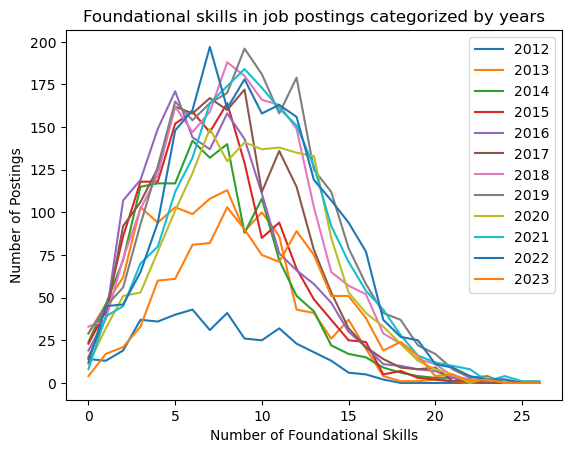

In [34]:
analysis_helper.plot_line_graph(count_skills_yearly_sorted.sort_index(axis=1), title="Foundational skills in job postings categorized by years")

In [35]:
document_counts_tf_yearly = analysis_helper.count_document_per_group_with_term_occurrences(grp_yearly, text_column=text_column, terms=word_mapping.keys())

Counting documents per group: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it]


In [36]:
analysis_helper.create_all_skill_tables(document_counts_tf_yearly, 'reports/document_counts_tf_yearly.xlsx')

In [38]:
term_occurrences_per_year = analysis_helper.count_document_per_group_with_total_term_occurrences(grp_yearly, text_column, word_mapping.keys())

Counting documents per group with total term occurrences: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it]


In [39]:
term_occurrences_per_year.to_csv('reports/term_occurrences_per_yearly.csv')
term_occurrences_per_year

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
2012,14,9,17,22,30,22,23,23,22,25,...,0,0,0,0,0,0,0,0,0,0
2013,29,43,45,61,81,71,69,50,64,74,...,0,0,0,0,0,0,0,0,0,0
2014,24,38,56,71,90,74,88,69,85,100,...,0,0,0,0,0,0,0,0,0,0
2015,23,34,62,76,92,96,97,103,86,93,...,0,0,0,0,0,0,0,0,0,0
2016,19,32,67,86,109,104,110,120,81,82,...,0,0,0,0,0,0,0,0,0,0
2017,15,35,67,71,90,89,105,130,98,101,...,0,0,0,0,0,0,0,0,0,0
2018,33,28,45,77,86,84,108,110,94,113,...,0,0,0,0,0,0,0,0,0,0
2019,29,33,42,55,75,110,97,111,105,93,...,0,0,0,0,0,0,0,0,0,0
2020,11,28,38,34,43,77,72,66,80,94,...,0,0,0,0,0,0,0,0,0,0
2021,8,33,38,40,39,64,76,66,101,120,...,0,0,0,0,0,0,0,0,0,0


In [40]:
print("Term Count:")

# Compute average along rows (axis=1)
average_values = grouped_year_term_counts.mean(axis=0)

# Sort the pivot table based on average values
grouped_year_term_counts = grouped_year_term_counts[average_values.sort_values(ascending=False).index]

grouped_year_term_counts.to_csv("reports/year_term_counts.csv")

grouped_year_term_counts

Term Count:


,keyword,active listen,goal,accountability,decision,decision make,creativity,curiosity,analytical,commitment,diverse,...,negotiation,speak,influence,hospitality,kindness,conflict management,social skill,persuasion,interpersonal communication,self organize
year,,,,,,,,,,,,,,,,,,,,,,
2012,term_count,512,460,370,368,328,268,140,143,136,147,...,20,16,2,4,3,0,1,0,0,0
2013,term_count,1607,1260,1210,1084,953,702,458,472,413,367,...,39,44,27,13,4,2,5,1,0,0
2014,term_count,1645,1283,1397,1003,882,673,530,469,356,409,...,72,46,29,28,12,6,3,1,1,0
2015,term_count,1975,1504,1627,1133,995,783,557,574,440,456,...,59,33,23,35,20,3,1,0,1,0
2016,term_count,2424,1579,1734,1183,1050,835,550,591,506,435,...,57,40,40,48,16,3,1,2,3,0
2017,term_count,2450,1876,1764,1611,1456,1028,706,706,587,564,...,45,68,31,72,29,5,2,3,0,0
2018,term_count,2957,2285,2163,2115,1914,1441,958,877,723,753,...,71,88,67,35,57,5,1,6,1,0
2019,term_count,3340,2267,2261,2500,2177,1766,1160,1224,1075,1017,...,97,102,79,50,54,7,6,5,3,0
2020,term_count,2739,1904,1785,1753,1523,1269,847,727,818,733,...,68,84,64,39,39,8,3,3,1,1


In [41]:
print("Term Frequencies:")

# Compute average along rows (axis=1)
average_values = grouped_year_term_frequencies.mean(axis=0)

# Sort the pivot table based on average values
grouped_year_term_frequencies = grouped_year_term_frequencies[average_values.sort_values(ascending=False).index]

grouped_year_term_frequencies.to_csv("reports/year_term_freq.csv")

grouped_year_term_frequencies


Term Frequencies:


,keyword,active listen,goal,accountability,decision,decision make,creativity,curiosity,analytical,diverse,commitment,...,negotiation,speak,influence,hospitality,kindness,conflict management,social skill,persuasion,interpersonal communication,self organize
year,,,,,,,,,,,,,,,,,,,,,,
2012,term_frequency,0.005194,0.004666,0.003753,0.003733,0.003327,0.002719,0.001420,0.001451,0.001491,0.001380,...,0.000203,0.000162,0.000020,0.000041,0.000030,0.000000,0.000010,0.000000,0.000000,0.000000
2013,term_frequency,0.005491,0.004306,0.004135,0.003704,0.003256,0.002399,0.001565,0.001613,0.001254,0.001411,...,0.000133,0.000150,0.000092,0.000044,0.000014,0.000007,0.000017,0.000003,0.000000,0.000000
2014,term_frequency,0.005251,0.004095,0.004459,0.003201,0.002815,0.002148,0.001692,0.001497,0.001305,0.001136,...,0.000230,0.000147,0.000093,0.000089,0.000038,0.000019,0.000010,0.000003,0.000003,0.000000
2015,term_frequency,0.005429,0.004134,0.004472,0.003114,0.002735,0.002152,0.001531,0.001578,0.001253,0.001209,...,0.000162,0.000091,0.000063,0.000096,0.000055,0.000008,0.000003,0.000000,0.000003,0.000000
2016,term_frequency,0.005996,0.003906,0.004289,0.002926,0.002597,0.002066,0.001361,0.001462,0.001076,0.001252,...,0.000141,0.000099,0.000099,0.000119,0.000040,0.000007,0.000002,0.000005,0.000007,0.000000
2017,term_frequency,0.005405,0.004139,0.003891,0.003554,0.003212,0.002268,0.001557,0.001557,0.001244,0.001295,...,0.000099,0.000150,0.000068,0.000159,0.000064,0.000011,0.000004,0.000007,0.000000,0.000000
2018,term_frequency,0.005369,0.004149,0.003928,0.003840,0.003475,0.002617,0.001740,0.001592,0.001367,0.001313,...,0.000129,0.000160,0.000122,0.000064,0.000104,0.000009,0.000002,0.000011,0.000002,0.000000
2019,term_frequency,0.005257,0.003568,0.003559,0.003935,0.003426,0.002780,0.001826,0.001926,0.001601,0.001692,...,0.000153,0.000161,0.000124,0.000079,0.000085,0.000011,0.000009,0.000008,0.000005,0.000000
2020,term_frequency,0.005554,0.003860,0.003619,0.003554,0.003088,0.002573,0.001717,0.001474,0.001486,0.001659,...,0.000138,0.000170,0.000130,0.000079,0.000079,0.000016,0.000006,0.000006,0.000002,0.000002


In [42]:
print("Document Frequencies:")
# Compute average along rows (axis=1)
average_values = grouped_year_document_frequencies.mean(axis=0)

# Sort the pivot table based on average values
grouped_year_document_frequencies = grouped_year_document_frequencies[average_values.sort_values(ascending=False).index]

grouped_year_document_frequencies.to_csv("reports/year_doc_freq.csv")

grouped_year_document_frequencies


Document Frequencies:


,,active listen,accountability,goal,decision,decision make,creativity,curiosity,detail,commitment,analytical,...,speak,negotiation,influence,kindness,hospitality,self organize,conflict management,social skill,persuasion,interpersonal communication
year,,,,,,,,,,,,,,,,,,,,,,
2012,document_frequency,0.577830,0.540094,0.497642,0.412736,0.391509,0.339623,0.264151,0.216981,0.250000,0.247642,...,0.037736,0.018868,0.004717,0.007075,0.004717,0.000000,0.000000,0.002358,0.000000,0.000000
2013,document_frequency,0.617550,0.590232,0.508278,0.408113,0.389073,0.331126,0.274007,0.200331,0.280629,0.286424,...,0.035596,0.023179,0.014073,0.003311,0.008278,0.003311,0.001656,0.004139,0.000828,0.000000
2014,document_frequency,0.597026,0.594796,0.514498,0.391822,0.370260,0.331599,0.280297,0.236431,0.211896,0.252045,...,0.033457,0.040149,0.017100,0.008922,0.020818,0.001487,0.003717,0.002230,0.000743,0.000743
2015,document_frequency,0.589077,0.633940,0.516255,0.364109,0.347204,0.323797,0.286086,0.268531,0.250975,0.258127,...,0.021456,0.026008,0.013004,0.013004,0.022757,0.002601,0.001300,0.000650,0.000000,0.000650
2016,document_frequency,0.648318,0.644037,0.534557,0.366361,0.337003,0.315596,0.233028,0.272171,0.258104,0.236697,...,0.024465,0.020795,0.023242,0.009174,0.021407,0.002446,0.001835,0.000612,0.001223,0.001835
2017,document_frequency,0.646499,0.622969,0.550700,0.425210,0.402241,0.357983,0.283473,0.286835,0.268908,0.262185,...,0.036975,0.020728,0.016246,0.015126,0.024650,0.002241,0.002241,0.001120,0.001681,0.000000
2018,document_frequency,0.633741,0.623472,0.555990,0.477262,0.459169,0.404890,0.321760,0.316870,0.280685,0.283619,...,0.040587,0.028851,0.028851,0.026406,0.015159,0.004890,0.002445,0.000489,0.002934,0.000489
2019,document_frequency,0.665317,0.621682,0.536662,0.496176,0.470535,0.433648,0.348628,0.332434,0.359424,0.310841,...,0.043185,0.031939,0.032839,0.022492,0.020693,0.004049,0.003149,0.002699,0.002249,0.001350
2020,document_frequency,0.678209,0.661493,0.560000,0.511642,0.476418,0.404776,0.342687,0.342090,0.367761,0.275821,...,0.047761,0.027463,0.035821,0.022687,0.020299,0.002985,0.004776,0.002388,0.001791,0.000597
